In [2]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences

In [4]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd


In [18]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.5200
True
{'login': 63134054, 'trade_mode': 2, 'leverage': 100, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 56.54, 'credit': 13.06, 'profit': 0.0, 'equity': 69.6, 'margin': 0.0, 'margin_free': 69.6, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'Bright Idowu ', 'server': 'OctaFX-Real', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5328, 'maxbars': 100000000, 'codepage': 0, 'ping_last': 161432,

In [19]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

69.6
AI is successfully functional


In [20]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = []
for symbol in symbols:
    if "USD" in symbol.name:
        print("Yes ", symbol.name)
        t_symbol.append(symbol.name)

print(len(t_symbol))

279
Yes  EURUSD
Yes  GBPUSD
Yes  USDJPY
Yes  USDCHF
Yes  AUDUSD
Yes  NZDUSD
Yes  USDCAD
Yes  USDMXN
Yes  USDZAR
Yes  XAGUSD
Yes  XAUUSD
Yes  XBRUSD
Yes  XTIUSD
Yes  XNGUSD
Yes  BTCUSD
Yes  ETHUSD
Yes  LTCUSD
Yes  XRPUSD
Yes  BCHUSD
Yes  AAVEUSD
Yes  ADAUSD
Yes  ALGOUSD
Yes  ATOMUSD
Yes  AVAXUSD
Yes  AXSUSD
Yes  BNBUSD
Yes  DASHUSD
Yes  DOGEUSD
Yes  DOTUSD
Yes  FILUSD
Yes  GRTUSD
Yes  ICPUSD
Yes  IOTAUSD
Yes  LINKUSD
Yes  LRCUSD
Yes  MANAUSD
Yes  NEARUSD
Yes  SOLUSD
Yes  UNIUSD
Yes  ZECUSD
Yes  ETCUSD
Yes  TRXUSD
Yes  FETUSD
Yes  ARBUSD
Yes  APTUSD
Yes  SUIUSD
Yes  USDCNH
Yes  USDCZK
Yes  USDDKK
Yes  USDHKD
Yes  USDHUF
Yes  USDNOK
Yes  USDPLN
Yes  USDSEK
Yes  USDSGD
Yes  USDTRY
Yes  XBRUSD.Daily
Yes  XTIUSD.Daily
Yes  BTCUSD.Daily
Yes  ETHUSD.Daily
Yes  XRPUSD.Daily
Yes  LTCUSD.Daily
Yes  BCHUSD.Daily
Yes  LINKUSD.Daily
Yes  SOLUSD.Daily
65


In [21]:

t_s = "AUDUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M5, 0, 10000000)
display(market)
print(market.shape)

print(t_s)
data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
df = pd.DataFrame(data, columns=["open", "high","low", "close"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

array([( 735868800, 0.7201 , 0.7265 , 0.713  , 0.715  , 2191, 50, 0),
       ( 735955200, 0.7144 , 0.7185 , 0.7103 , 0.7135 , 1551, 50, 0),
       ( 736041600, 0.7143 , 0.716  , 0.7095 , 0.7103 ,  901, 50, 0), ...,
       (1760744700, 0.64949, 0.64952, 0.64942, 0.64947,  120, 15, 0),
       (1760745000, 0.64946, 0.64953, 0.64932, 0.64935,  386, 14, 0),
       (1760745300, 0.64933, 0.64935, 0.64903, 0.64931,  481, 21, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

(1973010,)
AUDUSD


In [23]:

m_label = "GeneratedAUDUSD"
train_df = pd.read_csv(m_label+" dbot.csv")
#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 240 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape

X, y = create_sequences(train_df.values, SEQ_LEN, 5, 3)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)
#X1, y1 = create_sequences(train_df.values, SEQ_LEN, 5)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

n_samples = X.shape[0]
print(X[-1])
print(y[-1])

GeneratedAUDUSD
[[0.64807 0.64827 0.64807 0.64824]
 [0.64827 0.64838 0.64822 0.64836]
 [0.64836 0.64852 0.64832 0.64847]
 [0.64847 0.64861 0.64835 0.64844]
 [0.64847 0.64847 0.64822 0.64831]
 [0.6483  0.64884 0.64823 0.64874]
 [0.64873 0.64913 0.64867 0.64894]
 [0.64891 0.64904 0.64852 0.64856]
 [0.64854 0.64864 0.6484  0.6484 ]
 [0.64841 0.6486  0.64837 0.64837]
 [0.64837 0.64848 0.64828 0.6484 ]
 [0.6484  0.64856 0.64795 0.64811]
 [0.64811 0.6484  0.64811 0.64829]
 [0.64828 0.64834 0.64778 0.64793]
 [0.64792 0.64794 0.6476  0.64762]
 [0.64761 0.64761 0.64713 0.64714]
 [0.64712 0.64717 0.64697 0.64714]
 [0.64714 0.64722 0.64676 0.64677]
 [0.64678 0.64694 0.6465  0.64673]
 [0.64671 0.64722 0.64665 0.64707]
 [0.64708 0.64708 0.64682 0.64691]
 [0.64691 0.64698 0.64673 0.64675]
 [0.64675 0.64685 0.64667 0.64681]
 [0.64684 0.64693 0.64678 0.64687]
 [0.64685 0.64716 0.64685 0.64697]
 [0.64698 0.64703 0.64686 0.64688]
 [0.64688 0.64702 0.64678 0.64689]
 [0.64689 0.64692 0.64668 0.64676]
 [0.

In [ ]:
#X, y = preprocess_and_save_scalers(X, y, 'Volatility 75 Index scaler_x.joblib','Volatility 75 Index scaler_y.joblib')

Scaler for X saved to 'Volatility 75 Index scaler_x.joblib'
Scaler for Y saved to 'Volatility 75 Index scaler_y.joblib'


In [9]:
best_model = load_model("GeneratedAUDUSD lstm_best.keras")

In [10]:
best_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 4)]          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 240, 400)         328000    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 240, 400)         961600    
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 240, 400)         961600    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 400)              961600    
 onal)                                                     

In [24]:
y_pred = best_model.predict(X[-1000:])

32/32 [==============================] - 49s 2s/step


In [ ]:
_,y_test = inverse_transform_data(scaled_y=y[-1000:])
_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")

print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred_corrected))

[[794636.4103945]
 [793582.2808486]
 [793310.2474174]
 [793151.5612492]
 [792822.8541865]
 [795010.4563624]
 [794783.7618364]
 [796223.2720765]
 [797934.8157478]
 [797934.8157478]
 [797889.4768426]
 [797764.7948533]
 [797719.4559481]
 [797617.4434114]
 [797470.0919695]
 [797617.4434114]
 [797776.1295796]
 [797277.4016224]
 [796676.6611285]
 [797696.7864955]
 [797640.112864 ]
 [797968.8199267]
 [797968.8199267]
 [799362.9912616]
 [800122.4179237]
 [800133.75265  ]
 [801459.9156271]
 [800643.8153335]
 [800632.4806072]
 [799499.0079772]
 [799952.3970292]
 [800383.1166286]
 [799396.9954405]
 [799328.9870827]
 [798977.6105674]
 [799011.6147463]
 [799328.9870827]
 [799453.669072 ]
 [799249.6439986]
 [799669.0288717]
 [800156.4221026]
 [800417.1208075]
 [801799.9574161]
 [800949.8529436]
 [799805.0455873]
 [800167.7568289]
 [799963.7317555]
 [798569.5604206]
 [798116.1713686]
 [797288.7363487]
 [797572.1045062]
 [797492.7614221]
 [797209.3932646]
 [795044.4605413]
 [793434.9294067]
 [794647.7

ValueError: y_true and y_pred have different number of output (1!=5)

In [25]:
y_test = y[-1000:]
print(y_test, " comparing to ", y_pred)

# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")

print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred_corrected))
print(y_pred_corrected)

[[0.64528 0.64521 0.64541 0.6456  0.64589]
 [0.64521 0.64541 0.6456  0.64589 0.64572]
 [0.64541 0.6456  0.64589 0.64572 0.64558]
 ...
 [0.64973 0.64955 0.64948 0.64948 0.64947]
 [0.64955 0.64948 0.64948 0.64947 0.64935]
 [0.64948 0.64948 0.64947 0.64935 0.64931]]  comparing to  [[0.6456439  0.645846   0.6458178  0.6457403  0.645898  ]
 [0.6455441  0.64574635 0.6457181  0.6456405  0.6457983 ]
 [0.6454299  0.6456322  0.645604   0.6455264  0.6456842 ]
 ...
 [0.64955777 0.6497573  0.6497284  0.6496533  0.6498097 ]
 [0.6495379  0.64973754 0.64970857 0.6496334  0.6497899 ]
 [0.64950824 0.6497078  0.6496789  0.6496037  0.6497601 ]]
Average Gap (Bias): 0.0000942

--- Example of Correction ---
Original Prediction: 0.6456439
Corrected Prediction: 0.6457381
Actual Value:        0.6452800
R^2 value for  GeneratedAUDUSD
0.9223312019391303
[[0.6457381  0.64594024 0.64591205 0.6458345  0.6459922 ]
 [0.64563835 0.6458406  0.64581233 0.6457347  0.64589256]
 [0.64552414 0.64572644 0.64569825 0.64562064 

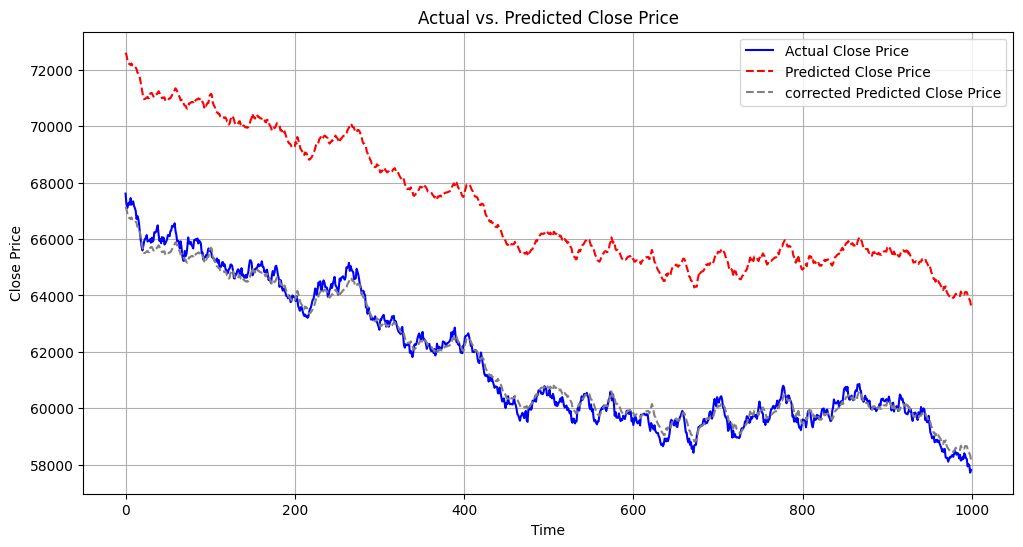

In [16]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual Close Price', color='blue')
plt.plot(y_pred[:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[:, 0], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()